# 3.5 图像分类数据集（Fashion-MNIST）
在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST [1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST [2]。这个数据集也比较小，只有几十M，这样没有GPU的电脑也能进行处理了。

----
![Fashion-MNIST数据集](../../TensorFlow/images/fashion-mnist-sprite.png)

----
![Fashion-MNIST数据集](../../TensorFlow/images/embedding.gif)

----
<center>☝图为Fashion-MNIST数据集</center>
    
本节我们将使用[`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html#torchvision)包，它是服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。[`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html#torchvision)主要由以下几部分构成：

1. [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision-datasets): 一些加载数据的函数及常用的数据集接口；
2. [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html#torchvision-models): 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等12模型；
3. [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision-transforms): 常用的图片变换，例如裁剪、旋转等；
4. [`torchvision.utils`](https://pytorch.org/docs/stable/torchvision/utils.html#torchvision-utils): 其他的一些有用的方法。



## 3.5.1 获取数据集
首先导入本节需要的包或模块。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

print(torch.__version__)
print(torchvision.__version__)

1.3.0+cpu
0.4.1+cpu


下面，我们通过PyTorch的[`torchvision.datasets.FashionMNIST`](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.FashionMNIST)包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。
另外我们还指定了参数`transform = transforms.ToTensor()`使所有数据转换为`Tensor`，如果不进行转换则返回的是PIL图片。`transforms.ToTensor()`将尺寸为 (H x W x C) 且数据位于[0, 255]的PIL图片或者数据类型为`np.uint8`的NumPy数组转换为尺寸为(C x H x W)且数据类型为`torch.float32`且位于[0.0, 1.0]的`Tensor`。
> 注意： 由于像素值为0到255的整数，所以刚好是uint8所能表示的范围，包括`transforms.ToTensor()`在内的一些关于图片的函数就默认输入的是uint8型，若不是，可能不会报错但的可能得不到想要的结果。所以，**如果用像素值(0-255整数)表示图片数据，那么一律将其类型设置成uint8，避免不必要的bug。** 这里处理比较复杂，详见[大神TangShusen的博客](https://tangshusen.me/2018/12/05/kaggle-doodle-reco/)。

>注：[PIL (Python Image Library)](https://en.wikipedia.org/wiki/Python_Imaging_Library) 是 Python 平台处理图片的API，强大的功能，形式简洁。

In [4]:
mnist_train = torchvision.datasets.FashionMNIST( 
    root='~/Datasets/FashionMNIST', #下载的数据集存在此处，如果慢可以用迅雷下，然后手动保存在这里
    train=True, 
    download=True,
    transform=transforms.ToTensor()) # 把图片信息转成Tensor

mnist_test = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST',
    train=False, 
    download=True,
    transform=transforms.ToTensor())
# print(mnist_train, mnist_test)

上面的`mnist_train`和`mnist_test`都是[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html)的子类，所以我们可以用`len()`来获取该数据集的大小，还可以用下标来获取具体的一个样本。训练集中和测试集中的每个类别的图像数分别为6,000和1,000。因为有10个类别，所以训练集和测试集的样本数分别为60,000和10,000。

In [5]:
print(len(mnist_train), len(mnist_test))

60000 10000


我们可以通过方括号[下标]来访问任意一个样本，下面获取第一个样本的图像和标签。

In [6]:
feature, label = mnist_train[0]

In [8]:
print(feature.shape, feature.dtype)  # Channel x Height X Width
print(label)

torch.Size([1, 28, 28]) torch.float32
9


变量`feature`对应高和宽均为28像素的图像。每个像素的数值为0到255之间8位无符号整数（uint8）。它使用三维的`Tensor`存储。其中的最后一维是通道数。因为数据集中是灰度图像，所以通道数为1。为了表述简洁，我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`(h，w)`。

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [10]:
mnist_PIL = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True)
PIL_feature, label = mnist_PIL[0]
print(PIL_feature)
print(label)

<PIL.Image.Image image mode=L size=28x28 at 0x1E639AB7320>
9


☝如果不指明`transform=transforms.ToTensor()`，则`torchvision.datasets.FashionMNIST()`的返回结果就是PIL图像而不是Tensor。

以下函数可以将数值标签转成相应的文本标签。

In [11]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [12]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

现在，我们看一下训练数据集中前10个样本的图像内容和文本标签。

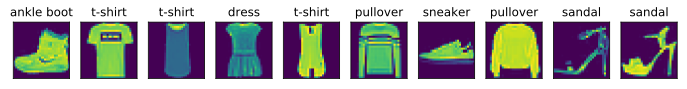

In [13]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 3.5.2 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。前面说过，`mnist_train`是`torch.utils.data.Dataset`的子类，所以我们可以将其传入`torch.utils.data.DataLoader`来创建一个读取小批量数据样本的DataLoader实例。

在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。PyTorch的`DataLoader`中一个很方便的功能是允许使用多进程来加速数据读取。这里我们通过参数`num_workers`来设置4个进程读取数据。

In [14]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

我们将获取并读取Fashion-MNIST数据集的逻辑封装在`d2lzh_pytorch.load_data_fashion_mnist`函数中供后面章节调用。该函数将返回`train_iter`和`test_iter`两个变量。随着本书内容的不断深入，我们会进一步改进该函数。它的完整实现将在5.6节中描述。

最后我们查看读取一遍训练数据需要的时间。

In [15]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

8.72 sec


## 小结

* Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
* 我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`(h，w)`。

## 练习

* 减小`batch_size`（如到1）会影响读取性能吗？
* 非Windows用户请尝试修改`num_workers`来查看它对读取性能的影响。
* 查阅Pytorch文档，`torchvision.datasets`里还提供了哪些别的数据集？
* 查阅Pytorch文档，`torchvision.transforms`还提供了哪些别的变换方法？

## 参考文献

[1] LeCun, Y., Cortes, C., & Burges, C. http://yann.lecun.com/exdb/mnist/

[2] Xiao, H., Rasul, K., & Vollgraf, R. (2017). Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747.